In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from glob import glob
%matplotlib inline

# Instructions for Use

The "Main Functions" section contains functions which return the success rate to be plotted as well as lower and upper bounds for uncertainty plotting.

To plot a given log, simply copy the code below two cells and replace `log_dir` with the path of the logs you wish to plot.

```
window = 1000
max_iter = None # Can set to an integer
log_dir = 'LOG_DIR'
title = 'Stack 4 Blocks, Training'
plot_it(log_dir, title, window=window, max_iter=max_iter)
```

# Main Functions

In [50]:
def get_grasp_success_rate(actions, rewards=None, window=200, reward_threshold=0.5):
    """Evaluate moving window of grasp success rate
    actions: Nx4 array of actions giving [id, rotation, i, j]
    
    """
    grasps = actions[:, 0] == 1
    if rewards is None:
        places = actions[:, 0] == 2
    success_rate = np.zeros(actions.shape[0] - 1)
    lower = np.zeros_like(success_rate)
    upper = np.zeros_like(success_rate)
    for i in range(success_rate.shape[0]):
        start = max(i - window, 0)
        if rewards is None:
            successes = places[start+1: i+2][grasps[start:i+1]]
        else:
            successes = (rewards[start: i+1] > reward_threshold)[grasps[start:i+1]]
        success_rate[i] = successes.mean()
        var = np.sqrt(success_rate[i] * (1 - success_rate[i]) / successes.shape[0])
        lower[i] = success_rate[i] + 3*var
        upper[i] = success_rate[i] - 3*var
    lower = np.clip(lower, 0, 1)
    upper = np.clip(upper, 0, 1)
    return success_rate, lower, upper

def get_place_success_rate(stack_height, actions, include_push=False, window=200, hot_fix=False, max_height=4):
    """
    stack_heights: length N array of integer stack heights
    actions: Nx4 array of actions giving [id, rotation, i, j]
    hot_fix: fix the stack_height bug, where the trial didn't end on successful pushes, which reached a stack of 4.
    
    where id=0 is a push, id=1 is grasp, and id=2 is place.
    
    """
    if hot_fix:
        indices = np.logical_or(stack_height < 4, np.array([True] + list(stack_height[:-1] < 4)))
        actions = actions[:stack_height.shape[0]][indices]
        stack_height = stack_height[indices]
    
    if include_push:
        success_possible = actions[:, 0] == 2
    else:
        success_possible = np.logical_or(actions[:, 0] == 0, actions[:, 0] == 2)
    
    stack_height_increased = np.zeros_like(stack_height, np.bool)
    stack_height_increased[0] = False
    stack_height_increased[1:] = stack_height[1:] > stack_height[:-1]
    
    success_rate = np.zeros_like(stack_height)
    lower = np.zeros_like(success_rate)
    upper = np.zeros_like(success_rate)
    for i in range(stack_height.shape[0]):
        start = max(i - window, 0)
        successes = stack_height_increased[start:i+1][success_possible[start:i+1]]
        success_rate[i] = successes.mean()
        success_rate[np.isnan(success_rate)] = 0
        var = np.sqrt(success_rate[i] * (1 - success_rate[i]) / successes.shape[0])
        lower[i] = success_rate[i] + 3*var
        upper[i] = success_rate[i] - 3*var
    lower = np.clip(lower, 0, 1)
    upper = np.clip(upper, 0, 1)
    return success_rate, lower, upper

def get_action_efficiency(stack_height, window=200, ideal_actions_per_trial=6, max_height=4):
    """Calculate the running action efficiency from successful trials.

    trials: array giving the number of trials up to iteration i (TODO: unused?)
    min_actions: ideal number of actions per trial
    
    Formula: successful_trial_count * ideal_actions_per_trial / window_size
    """

    success = stack_height == max_height
    efficiency = np.zeros_like(stack_height, np.float64)
    lower = np.zeros_like(efficiency)
    upper = np.zeros_like(efficiency)
    for i in range(1, efficiency.shape[0]):
        start = max(i - window, 1)
        window_size = min(i, window)
        num_trials = success[start:i+1].sum()
        efficiency[i] = num_trials * ideal_actions_per_trial / window_size
        var = efficiency[i] / np.sqrt(window_size)
        lower[i] = efficiency[i] + 3*var
        upper[i] = efficiency[i] - 3*var
    lower = np.clip(lower, 0, 1)
    upper = np.clip(upper, 0, 1)
    return efficiency, lower, upper

def get_grasp_action_efficiency(actions, rewards, reward_threshold=0.5, window=200, ideal_actions_per_trial=3):
    """Get grasp efficiency from when the trial count increases.
    
    """
    grasps = actions[:, 0] == 1
    efficiency = np.zeros_like(rewards, np.float64)
    lower = np.zeros_like(efficiency)
    upper = np.zeros_like(efficiency)
    for i in range(efficiency.shape[0]):
        start = max(i - window, 0)
        window_size = min(i+1, window)
        successful = rewards[start: i+1] > reward_threshold
        successful_grasps = successful[grasps[start:start+successful.shape[0]]].sum()
        efficiency[i] = successful_grasps / window_size
        var = efficiency[i] / np.sqrt(window_size)
        lower[i] = efficiency[i] + 3*var
        upper[i] = efficiency[i] - 3*var
    lower = np.clip(lower, 0, 1)
    upper = np.clip(upper, 0, 1)
    return efficiency, lower, upper

In [46]:
def plot_it(log_dir, title, window=1000, colors=['tab:blue', 'tab:green', 'tab:orange'], alpha=0.35, mult=100, max_iter=None, place=False):
    if place:
        heights = np.loadtxt(os.path.join(log_dir, 'transitions', 'stack-height.log.txt'))
        rewards = None
    else:
        rewards = np.loadtxt(os.path.join(log_dir, 'transitions', 'reward-value.log.txt'))
    actions = np.loadtxt(os.path.join(log_dir, 'transitions', 'executed-action.log.txt'))
    trials = np.loadtxt(os.path.join(log_dir, 'transitions', 'trial.log.txt'))
    
    if max_iter is not None:
        if place:
            heights = heights[:max_iter]
        else:
            rewards = rewards[:max_iter]
        actions = actions[:max_iter]
        trials = trials[:max_iter]
    
    grasp_rate, grasp_lower, grasp_upper = get_grasp_success_rate(actions, rewards=rewards, window=window)
    if place:
        if 'row' in log_dir or 'row' in title.lower():
            place_rate, place_lower, place_upper = get_place_success_rate(heights, actions, include_push=True, hot_fix=True, window=window)
        else:
            place_rate, place_lower, place_upper = get_place_success_rate(heights, actions, window=window)
        eff, eff_lower, eff_upper = get_action_efficiency(heights, window=window)
    else:
        eff, eff_lower, eff_upper = get_grasp_action_efficiency(actions, rewards, window=window)

    plt.plot(mult*grasp_rate, color=colors[0], label='Grasp Success Rate')
    if place:
        plt.plot(mult*place_rate, color=colors[1], label='Place Success Rate')
    plt.plot(mult*eff, color=colors[2], label='Action Efficiency')

    plt.fill_between(np.arange(1, grasp_rate.shape[0]+1), 
                     mult*grasp_lower, mult*grasp_upper,
                     color=colors[0], alpha=alpha)
    if place:
        plt.fill_between(np.arange(1, place_rate.shape[0]+1), 
                         mult*place_lower, mult*place_upper,
                         color=colors[1], alpha=alpha)
    plt.fill_between(np.arange(1, eff.shape[0]+1), 
                     mult*eff_lower, mult*eff_upper,
                     color=colors[2], alpha=alpha)

    ax = plt.gca()
    plt.xlabel('Iteration')
    plt.ylabel('Running Mean')
    plt.title(title)
    plt.legend()
    ax.yaxis.set_major_formatter(PercentFormatter())
    plt.savefig(log_dir + '_success_plot.pdf')

# Any-object Stacking

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


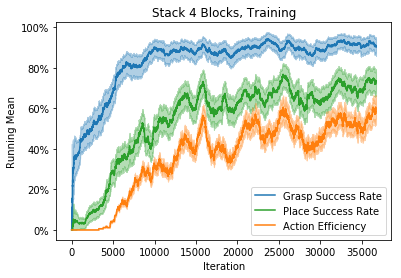

In [20]:
window = 1000
max_iter = None
log_dir = 'any-stack-v2-steps-37k'
title = 'Stack 4 Blocks, Training'
plot_it(log_dir, title, window=window, max_iter=max_iter)

# Arranging Rows

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


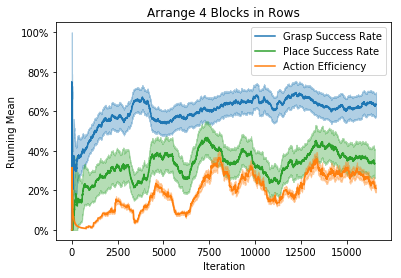

In [21]:
window = 1000
max_iter = None
log_dir = '../logs/2019-09-13.19-55-21-train-rows-no-images-16.5k'
title = 'Arrange 4 Blocks in Rows'
plot_it(log_dir, title, window=window, max_iter=max_iter)

# Push + Grasp

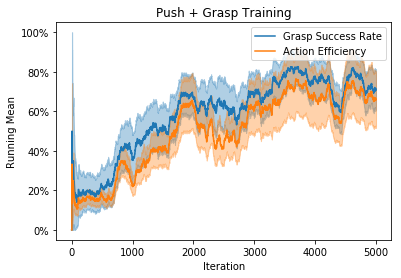

In [51]:
window = 200
max_iter = 5000
log_dir = 'train-grasp-place-split-efficientnet-21k-acc'
title = 'Push + Grasp Training'
plot_it(log_dir, title, window=window, max_iter=max_iter, place=False)